# Step 5. Modelling and Hyperparameter Tuning

**Question:**

**Can we accurately predict the number of awards issued per 100 full-time undergraduate students at higher education institutions using institutional characteristics as predictors?**

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR
from datetime import datetime, date
from scipy.stats import randint
import warnings  
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy")

## Data

In [2]:
df = pd.read_csv('preprocessed_collegedata.csv')

**Convert the target variable 'awards_per_value' into categorical variable using 3 bins.**

In [3]:
df['awards_per_value'].describe()

count    3798.000000
mean       21.038705
std         6.609650
min         3.000000
25%        17.000000
50%        21.000000
75%        24.000000
max        40.000000
Name: awards_per_value, dtype: float64

In [4]:
# Define bins and labels
bins = [0, 20, 40]
labels = ['Low', 'High']

# Create a new column 'num_awards_given' with the binned data
df['num_awards_given'] = pd.cut(df['awards_per_value'], bins=bins, labels=labels, include_lowest=True)

# Drop the 'awards_per_value' column
df = df.drop(columns=['awards_per_value'])

print(df.head())

   student_count  awards_per_state_value  awards_per_natl_value  \
0           4051                    18.8                   21.5   
1          11502                    18.8                   21.5   
2            322                    17.8                   22.5   
3           5696                    18.8                   21.5   
4           5356                    18.8                   21.5   

   exp_award_value  exp_award_state_value  exp_award_natl_value  ft_pct  \
0         105331.0                  75743                 66436    93.8   
1         136546.0                  75743                 66436    72.7   
2          58414.0                  92268                101725    62.7   
3          64418.0                  75743                 66436    74.4   
4         132407.0                  75743                 66436    91.0   

   fte_value  aid_value   endow_value  ...  pell_value  retain_value  \
0       3906     7142.0   8677.865366  ...        71.2            63   
1 

In [5]:
df['num_awards_given'].dtype

CategoricalDtype(categories=['Low', 'High'], ordered=True, categories_dtype=object)

## Split Data

In [6]:
X = df.drop(columns=['num_awards_given'])
y = df['num_awards_given']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape

((3038, 21), (760, 21))

## Scaled X_train, X_test Data

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Is the data balanced?**

num_awards_given
High    2020
Low     1778
Name: count, dtype: int64


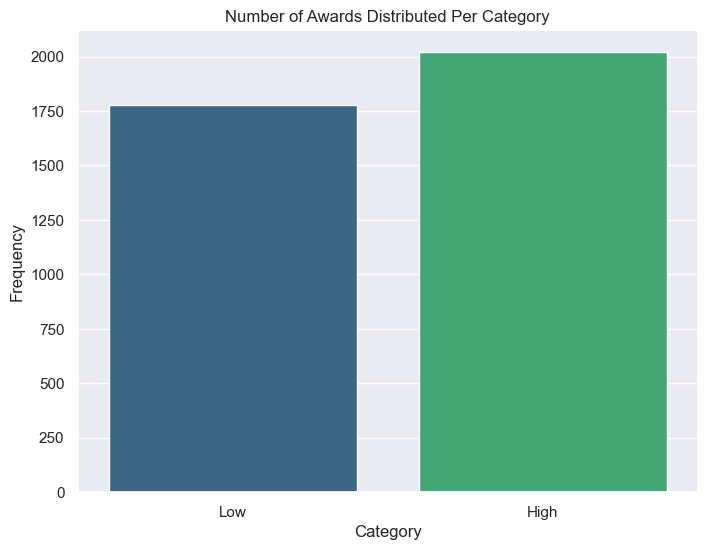

In [8]:
# Count the frequency of each class
class_counts = df['num_awards_given'].value_counts()

# Print the counts of each class
print(class_counts)

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Number of Awards Distributed Per Category')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show();

## Train, Test, Predict.

In [9]:
# Create a k-NN classifier
knn = KNeighborsClassifier()

# Fit the classifier to the training data
knn.fit(X_train_scaled, y_train)

# Print the accuracy
print(knn.score(X_test_scaled, y_test))

0.7552631578947369


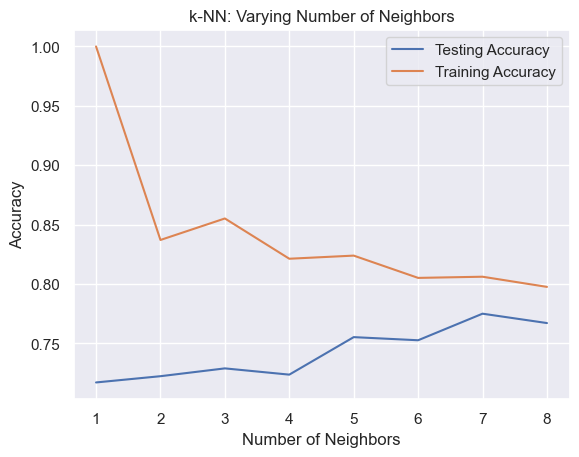

In [10]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors = k)

    # Fit the classifier to the training data
    knn.fit(X_train_scaled, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train_scaled, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test_scaled, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show();

### k-NN GridSearchCV

Best parameters: {'n_neighbors': 35}
Best cross-validation score: 0.7577
Test set accuracy: 0.7868
[[339  59]
 [103 259]]
              precision    recall  f1-score   support

        High       0.77      0.85      0.81       398
         Low       0.81      0.72      0.76       362

    accuracy                           0.79       760
   macro avg       0.79      0.78      0.78       760
weighted avg       0.79      0.79      0.79       760



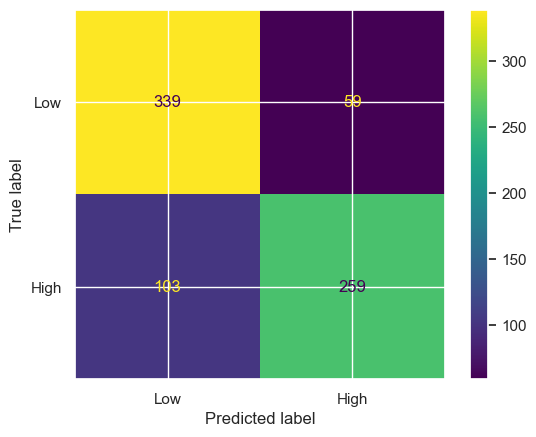

In [11]:
# Create an instance of KNeighborsClassifier
knn = KNeighborsClassifier()

# Define parameter grid for GridSearchCV
param_grid = {'n_neighbors': range(1, 50)}

# Perform grid search with 5-fold cross-validation
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train_scaled, y_train)

# Best parameters and cross-validation score
print(f'Best parameters: {knn_cv.best_params_}')
print(f'Best cross-validation score: {knn_cv.best_score_:.4f}')

# Evaluate the best model on the test set
best_knn = knn_cv.best_estimator_
test_accuracy = best_knn.score(X_test_scaled, y_test)
print(f'Test set accuracy: {test_accuracy:.4f}')

# Make predictions on the test set
y_pred_knn = best_knn.predict(X_test_scaled)

# Print confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred_knn)
print(cm)

cmd = ConfusionMatrixDisplay(cm, display_labels=['Low', 'High'])
cmd.plot();

print(classification_report(y_test, y_pred_knn))

### Random Forest, GridSearchCV

In [12]:
# Find the optimal parameters
param_rf = {'n_estimators':np.arange(1,50)}
rf = RandomForestClassifier(param_rf)
rf_cv= GridSearchCV(rf,param_grid=param_rf,cv=5)
rf_cv.fit(X_train_scaled, y_train)

print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.7886759732940258
Best Parameters: {'n_estimators': 39}


Test set accuracy: 0.8118
[[337  61]
 [ 82 280]]


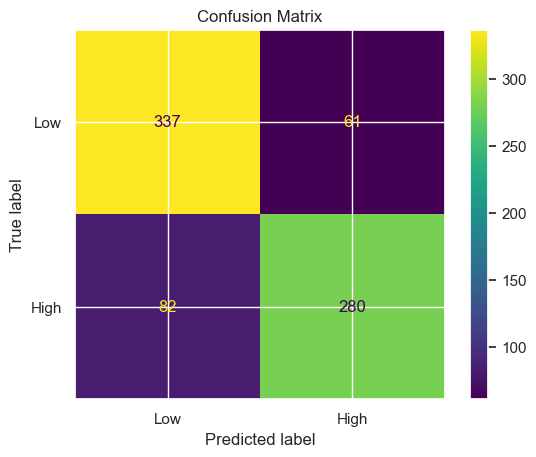

              precision    recall  f1-score   support

        High       0.80      0.85      0.82       398
         Low       0.82      0.77      0.80       362

    accuracy                           0.81       760
   macro avg       0.81      0.81      0.81       760
weighted avg       0.81      0.81      0.81       760



In [13]:
# Define and train the model with the best parameters
rf_params = rf_cv.best_params_
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred_rf = rf_model.predict(X_test_scaled)
rf_test_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Test set accuracy: {rf_test_accuracy:.4f}')

# Print confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Display confusion matrix
cmd_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Low', 'High'])
cmd_rf.plot()
plt.title('Confusion Matrix')
plt.show();

# Print classification report
print(classification_report(y_test, y_pred_rf))

### Random Forest, RandomizedSearchCV

Start time: 2024-07-12 08:39:43.357649
Fitting 5 folds for each of 100 candidates, totalling 500 fits
End time: 2024-07-12 08:45:49.726607
Best parameters found:  {'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 214, 'random_state': 42}
Best score:  0.7840625812884765
Test set score:  0.8118421052631579


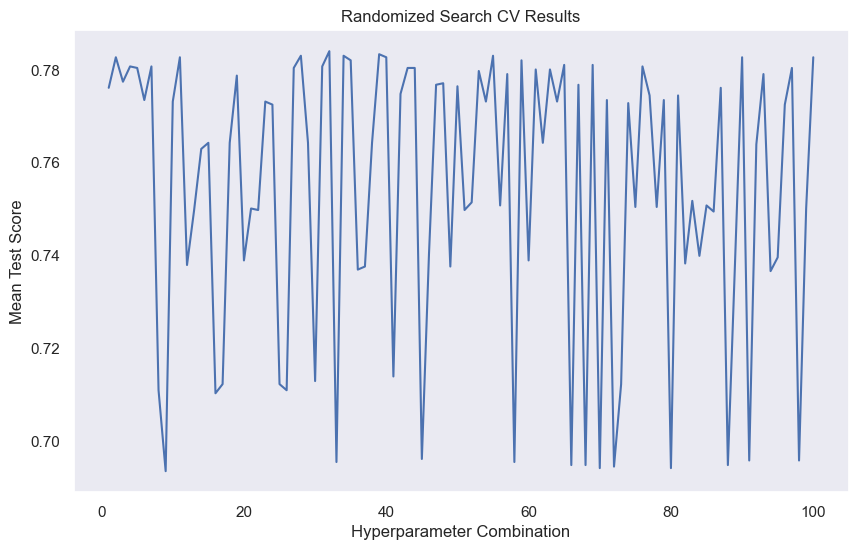

In [14]:
# Find the optimal parameters
# Define parameters
random_grid = { 
    'n_estimators': randint(200, 600),
    'max_features': ['sqrt', 'log2'],
    'max_depth': randint(1, 10),
    'random_state': [42]
}
# Show start time
print("Start time:", datetime.now())

# Perform random search
r_search = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                              param_distributions=random_grid, n_iter=100, cv=5, random_state=42, verbose=2, n_jobs=-1)
r_search.fit(X_train_scaled, y_train)

# Show end time
print("End time:", datetime.now())

# Print the best parameters
print("Best parameters found: ", r_search.best_params_)

# Print the best score
print("Best score: ", r_search.best_score_)

# Evaluate the best model on the test set
best_model = r_search.best_estimator_
test_score = best_model.score(X_test_scaled, y_test)
print("Test set score: ", test_score)

# Visualize performance across different hyperparameter combinations
results = r_search.cv_results_
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Randomized Search CV Results')
plt.grid()
plt.show();

Test set accuracy: 0.8118
[[342  56]
 [ 87 275]]


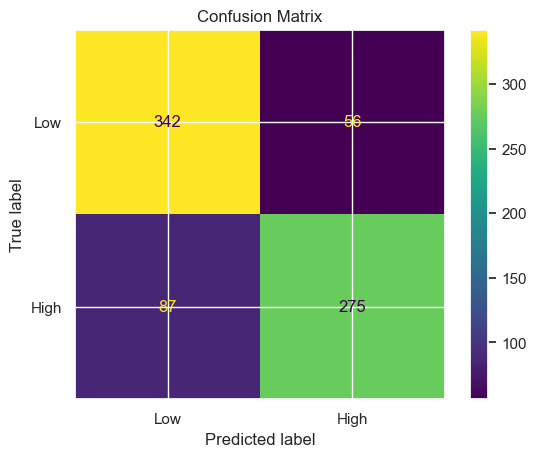

              precision    recall  f1-score   support

        High       0.80      0.86      0.83       398
         Low       0.83      0.76      0.79       362

    accuracy                           0.81       760
   macro avg       0.81      0.81      0.81       760
weighted avg       0.81      0.81      0.81       760



In [15]:
# Define and train the model with the best parameters
model_3_params = r_search.best_params_
model_3 = RandomForestClassifier(**model_3_params)
model_3.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred_3 = model_3.predict(X_test_scaled)
test_accuracy3 = accuracy_score(y_test, y_pred_3)
print(f'Test set accuracy: {test_accuracy3:.4f}')

# Print confusion matrix
cm3 = confusion_matrix(y_test, y_pred_3)
print(cm3)

# Display confusion matrix
cmd3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['Low', 'High'])
cmd3.plot();
plt.title('Confusion Matrix')
plt.show();

# Print classification report
print(classification_report(y_test, y_pred_3))

### Logistic Regression

In [20]:
# Define the parameter grid for hyperparameter tuning
log_params_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

# Instantiate the logistic regression model
log_reg = LogisticRegression(random_state=42)

# Perform grid search on the training data
log_grid = GridSearchCV(estimator=log_reg, param_grid=log_params_grid, cv=5, n_jobs=-1, verbose=2)
log_grid.fit(X_train_scaled, y_train)

# Print the best parameters found
best_log_params = log_grid.best_params_
print("Best parameters found: ", best_log_params)

# Train the logistic regression model with the best parameters
best_log_reg = LogisticRegression(**best_log_params, random_state=42)
best_log_reg.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred_log = best_log_reg.predict(X_test_scaled)
test_accuracy_log = accuracy_score(y_test, y_pred_log)
print(f'Test set accuracy: {test_accuracy_log:.4f}')

# Print confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log)
print(cm_log)

# Display confusion matrix
cmd_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=['Low', 'High'])
cmd_log.plot()
plt.title('Confusion Matrix')
plt.show();

# Print classification report
print(classification_report(y_test, y_pred_log))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\MTIDES\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\MTIDES\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\MTIDES\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\MTIDES\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solv

TypeError: LogisticRegression.fit() got an unexpected keyword argument 'error_score'